## Блок 1: Импорты

In [1]:
import os
import time
import pandas as pd
import glob
import yfinance as yf
from tqdm import tqdm
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

## Блок 2: Конфигурация

In [2]:
DATA_DIR = "full_history/full_history"
NEWS_FILES = ["All_external.csv", "nasdaq_exteral_data.csv"]
META_CACHE = "ticker_meta_yahoo.csv"

START_DATE = pd.to_datetime("2019-01-01")
END_DATE = pd.to_datetime("2023-12-31")

TRADING_DAYS_EXPECTED = len(pd.bdate_range(START_DATE, END_DATE))
EDGE_TOLERANCE_DAYS = 31

THRESHOLD_PRICE_ROWS = 1000
THRESHOLD_NEWS_COUNT = 50
THRESHOLD_COVERAGE_PCT = 80

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

BASE_URL = "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main"
CHUNKSIZE = 200_000

## Блок 3: Вспомогательные функции

In [3]:
def download_file(url, filename):
    if os.path.exists(filename) and os.path.getsize(filename) > 0:
        print(f"Файл уже существует: {filename}")
        return
    print(f"Скачиваю {filename}...")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    total_size = int(resp.headers.get("content-length", 0))
    with open(filename, "wb") as f:
        with tqdm(total=total_size, unit="B", unit_scale=True, unit_divisor=1024) as pbar:
            for chunk in resp.iter_content(1024 * 1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    print(f"Готово: {filename}")

def normalize_ticker_for_yahoo(ticker):
    return str(ticker).replace(".", "-").strip()

def get_company_metadata(ticker):
    symbol = normalize_ticker_for_yahoo(ticker)
    try:
        info = yf.Ticker(symbol).get_info()
        return {
            "ticker": str(ticker),
            "yahoo_symbol": symbol,
            "company_name": info.get("longName") or info.get("shortName"),
            "sector": info.get("sector"),
            "industry": info.get("industry"),
            "exchange": info.get("exchange"),
            "quoteType": info.get("quoteType")
        }
    except Exception:
        return {
            "ticker": str(ticker), "yahoo_symbol": symbol,
            "company_name": None, "sector": None, "industry": None,
            "exchange": None, "quoteType": None
        }
    finally:
        time.sleep(0.25)

def load_or_create_meta_cache(path):
    if os.path.exists(path) and os.path.getsize(path) > 0:
        try:
            return pd.read_csv(path)
        except Exception:
            pass
    return pd.DataFrame(columns=[
        "ticker", "yahoo_symbol", "company_name", 
        "sector", "industry", "exchange", "quoteType"
    ])

def fetch_missing_metadata(tickers, cache_path):
    cache = load_or_create_meta_cache(cache_path)
    cached_tickers = set(cache["ticker"].astype(str))
    missing = [t for t in tickers if str(t) not in cached_tickers]
    print(f"[МЕТА] В кэше: {len(cached_tickers)}, нужно загрузить: {len(missing)}")
    if missing:
        new_records = [get_company_metadata(t) for t in tqdm(missing, desc="Метаданные Yahoo")]
        cache = pd.concat([cache, pd.DataFrame(new_records)], ignore_index=True)
        cache = cache.drop_duplicates(subset=["ticker"], keep="last")
        cache.to_csv(cache_path, index=False)
        print(f"[МЕТА] Кэш сохранён: {cache_path}")
    return cache

def aggregate_news_statistics(file_paths, valid_tickers, chunksize=200_000):
    counts, min_dates, max_dates = {}, {}, {}
    for filepath in file_paths:
        for chunk in tqdm(pd.read_csv(filepath, chunksize=chunksize, low_memory=False),
                         desc=f"Обработка {os.path.basename(filepath)}"):
            chunk = chunk.rename(columns={"Date": "date", "Stock_symbol": "ticker"})
            if "date" not in chunk.columns or "ticker" not in chunk.columns:
                continue
            chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce", utc=True).dt.tz_convert(None).dt.normalize()
            chunk = chunk.dropna(subset=["date", "ticker"])
            chunk = chunk[(chunk["date"] >= START_DATE) & (chunk["date"] <= END_DATE)]
            chunk["ticker"] = chunk["ticker"].astype(str).str.strip()
            chunk = chunk[chunk["ticker"].isin(valid_tickers)]
            if chunk.empty:
                continue
            grouped = chunk.groupby("ticker")["date"].agg(["count", "min", "max"])
            for ticker, row in grouped.iterrows():
                counts[ticker] = counts.get(ticker, 0) + int(row["count"])
                min_dates[ticker] = row["min"] if ticker not in min_dates else min(min_dates[ticker], row["min"])
                max_dates[ticker] = row["max"] if ticker not in max_dates else max(max_dates[ticker], row["max"])
    return pd.DataFrame({
        "ticker": list(counts.keys()),
        "news_count": [counts[t] for t in counts],
        "news_min_date": [min_dates[t] for t in counts],
        "news_max_date": [max_dates[t] for t in counts]
    })

def analyze_price_coverage(data_dir, start, end, expected_days, edge_tolerance_days=31, max_errors=10):
    files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
    results = []
    errors = []

    for filename in tqdm(files, desc="Анализ цен"):
        ticker = filename[:-4]
        try:
            df = pd.read_csv(os.path.join(data_dir, filename), low_memory=False)

            if "Date" in df.columns and "date" not in df.columns:
                df = df.rename(columns={"Date": "date"})
            if "date" not in df.columns:
                continue

            df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
            df = df.dropna(subset=["date"])
            df = df[(df["date"] >= start) & (df["date"] <= end)]
            if df.empty:
                continue

            df = df.drop_duplicates(subset=["date"])
            n_days = int(df["date"].nunique())
            date_min, date_max = df["date"].min(), df["date"].max()

            coverage = n_days / expected_days * 100
            starts_ok = date_min <= (start + pd.Timedelta(days=edge_tolerance_days))
            ends_ok = date_max >= (end - pd.Timedelta(days=edge_tolerance_days))

            results.append({
                "ticker": ticker,
                "price_rows": n_days,
                "price_min_date": date_min,
                "price_max_date": date_max,
                "coverage_pct": round(coverage, 1),
                "starts_in_2019": starts_ok,
                "ends_in_2023": ends_ok,
                "full_coverage": bool(starts_ok and ends_ok)
            })

        except Exception as e:
            if len(errors) < max_errors:
                errors.append((ticker, str(e)))
            continue

    if errors:
        print(f"[Покрытие цен] Ошибки чтения: {len(errors)} (показаны первые {min(len(errors), max_errors)})")
        for t, msg in errors[:max_errors]:
            print(f" - {t}: {msg}")

    return pd.DataFrame(results)

def apply_quality_filters(df, min_rows, min_news, min_coverage):
    return (
        (df["full_coverage"] == True) &
        (df["price_rows"] >= min_rows) &
        (df["news_count"] >= min_news) &
        (df["coverage_pct"] >= min_coverage)
    )

def print_summary(df, title):
    line = "=" * 60
    print("\n" + line)
    print(title)
    print(line)
    print(f"Всего компаний: {len(df)}")
    print(f"Период: {START_DATE.date()} — {END_DATE.date()}")
    if len(df) > 0:
        if "price_rows" in df.columns:
            print(f"Среднее число торговых дней с ценами: {df['price_rows'].mean():.0f}")
            print(f"Мин/макс торговых дней: {df['price_rows'].min():.0f} / {df['price_rows'].max():.0f}")
        if "news_count" in df.columns:
            print(
                f"Новости на компанию — среднее: {df['news_count'].mean():.0f}, "
                f"медиана: {df['news_count'].median():.0f}, "
                f"диапазон: [{df['news_count'].min()}, {df['news_count'].max()}]"
            )

def print_step(title):
    line = "=" * 60
    print(line)
    print(title)
    print(line)

## Блок 4: Скачивание данных

In [4]:
print_step("ШАГ 0: Скачивание и подготовка данных")
news_files_download = {
    "All_external.csv": "Stock_news/All_external.csv",
    "nasdaq_exteral_data.csv": "Stock_news/nasdaq_exteral_data.csv",
}

for local_name, remote_path in news_files_download.items():
    download_file(f"{BASE_URL}/{remote_path}", local_name)

zip_filename = "full_history.zip"
download_file(f"{BASE_URL}/Stock_price/full_history.zip", zip_filename)

target_dir = os.path.join("full_history", "full_history")
has_prices = os.path.isdir(target_dir) and len(glob.glob(os.path.join(target_dir, "*.csv"))) > 0

if not has_prices:
    print("Распаковываю full_history.zip...")
    with zipfile.ZipFile(zip_filename, "r") as z:
        z.extractall("full_history")
    print("Готово: данные распакованы в full_history/")
else:
    print("Папка с ценами уже существует и не пустая: распаковку пропускаю")

ШАГ 0: Скачивание и подготовка данных
Файл уже существует: All_external.csv
Файл уже существует: nasdaq_exteral_data.csv
Файл уже существует: full_history.zip
Папка с ценами уже существует и не пустая: распаковку пропускаю


## Блок 5: Основной пайплайн

In [5]:
PRICE_CACHE = "cache_price_coverage_2019_2023.csv"
NEWS_CACHE = "cache_news_stats_2019_2023.csv"

In [6]:
print_step("ШАГ 1: Анализ покрытия данных по ценам (2019–2023)")

if os.path.exists(PRICE_CACHE):
    price_data = pd.read_csv(PRICE_CACHE, parse_dates=["price_min_date", "price_max_date"])
else:
    price_data = analyze_price_coverage(
        DATA_DIR, START_DATE, END_DATE, TRADING_DAYS_EXPECTED, edge_tolerance_days=EDGE_TOLERANCE_DAYS
    )
    price_data.to_csv(PRICE_CACHE, index=False)

print(f"Тикеров с ценами в периоде: {len(price_data)}")
print(f"Тикеров с полным покрытием (с допуском): {int(price_data['full_coverage'].sum())}")

print_step("ШАГ 2: Агрегация статистики новостей (2019–2023)")

valid_tickers = set(price_data["ticker"].astype(str))

if os.path.exists(NEWS_CACHE):
    news_data = pd.read_csv(NEWS_CACHE, parse_dates=["news_min_date", "news_max_date"])
else:
    news_data = aggregate_news_statistics(NEWS_FILES, valid_tickers, chunksize=CHUNKSIZE)
    news_data.to_csv(NEWS_CACHE, index=False)

print(f"Тикеров с новостями в периоде: {len(news_data)}")

print_step("ШАГ 3: Объединение и фильтрация данных")

combined = price_data.merge(news_data, on="ticker", how="inner")
combined["passes_filters"] = apply_quality_filters(
    combined, THRESHOLD_PRICE_ROWS, THRESHOLD_NEWS_COUNT, THRESHOLD_COVERAGE_PCT
)

print(f"Тикеров с ценами и новостями (после объединения): {len(combined)}")
print(f"Тикеров, прошедших все фильтры качества: {int(combined['passes_filters'].sum())}")

print_step("ШАГ 4: Обогащение метаданными компании (Yahoo Finance)")

filtered = combined[combined["passes_filters"]].sort_values("news_count", ascending=False)
metadata = fetch_missing_metadata(filtered["ticker"].tolist(), META_CACHE)

final_dataset = filtered.merge(
    metadata[["ticker", "company_name", "sector", "industry", "exchange", "quoteType"]],
    on="ticker", how="left"
)

output_columns = [
    "ticker", "company_name", "sector", "industry", "exchange", "quoteType",
    "price_rows", "price_min_date", "price_max_date", "coverage_pct",
    "starts_in_2019", "ends_in_2023", "full_coverage",
    "news_count", "news_min_date", "news_max_date"
]
final_dataset = final_dataset[output_columns].reset_index(drop=True)

quality_report = pd.DataFrame([
    ["Тикеры с ценами в периоде", len(price_data)],
    ["Тикеры с полным покрытием (с допуском)", int(price_data["full_coverage"].sum())],
    ["Тикеры с новостями в периоде", len(news_data)],
    ["Тикеры после объединения (inner join)", len(combined)],
    ["Тикеры после фильтров качества", int(combined["passes_filters"].sum())],
    ["Итоговая выборка", len(final_dataset)],
    ["Итоговая выборка: EQUITY", int((final_dataset["quoteType"] == "EQUITY").sum())],
], columns=["Этап", "Количество"])

quality_report.to_csv("data_quality_report.csv", index=False)
quality_report

ШАГ 1: Анализ покрытия данных по ценам (2019–2023)
Тикеров с ценами в периоде: 7691
Тикеров с полным покрытием (с допуском): 4068
ШАГ 2: Агрегация статистики новостей (2019–2023)
Тикеров с новостями в периоде: 5790
ШАГ 3: Объединение и фильтрация данных
Тикеров с ценами и новостями (после объединения): 5790
Тикеров, прошедших все фильтры качества: 2957
ШАГ 4: Обогащение метаданными компании (Yahoo Finance)
[МЕТА] В кэше: 2977, нужно загрузить: 0


,Этап,Количество
0,Тикеры с ценами в периоде,7691
1,Тикеры с полным покрытием (с допуском),4068
2,Тикеры с новостями в периоде,5790
3,Тикеры после объединения (inner join),5790
4,Тикеры после фильтров качества,2957
5,Итоговая выборка,2957
6,Итоговая выборка: EQUITY,2193


## Блок 6.1: Сохранение результатов по тикерам

In [7]:
print_step("ШАГ 5: Сохранение результатов")

final_dataset.to_csv("selected_companies_2019_2023.csv", index=False)
print("Файл сохранён: selected_companies_2019_2023.csv")

equities = final_dataset[final_dataset["quoteType"] == "EQUITY"].copy()
equities.to_csv("selected_equities_only_2019_2023.csv", index=False)
print(f"Файл сохранён: selected_equities_only_2019_2023.csv (акций: {len(equities)})")

pd.DataFrame({"ticker": final_dataset["ticker"]}).to_csv("selected_tickers.csv", index=False)
print("Файл сохранён: selected_tickers.csv")

print_summary(final_dataset, "СВОДКА ИТОГОВОЙ ВЫБОРКИ")

print("\nТип инструмента (quoteType):")
print(final_dataset["quoteType"].value_counts().to_string())

print("\nСектора (топ-10):")
print(final_dataset["sector"].value_counts().head(10).to_string())

print("\nБиржи (exchange):")
print(final_dataset["exchange"].value_counts().to_string())

print_step("Топ-10 компаний по числу новостей")

display_cols = ["ticker", "company_name", "sector", "exchange", "price_rows", "news_count"]
display_cols_ru = {
    "ticker": "Тикер",
    "company_name": "Компания",
    "sector": "Сектор",
    "exchange": "Биржа",
    "price_rows": "Торг. дней с ценами",
    "news_count": "Новостей"
}
top10 = final_dataset[display_cols].head(10).rename(columns=display_cols_ru)
print(top10.to_string(index=False))

ШАГ 5: Сохранение результатов
Файл сохранён: selected_companies_2019_2023.csv
Файл сохранён: selected_equities_only_2019_2023.csv (акций: 2193)
Файл сохранён: selected_tickers.csv

СВОДКА ИТОГОВОЙ ВЫБОРКИ
Всего компаний: 2957
Период: 2019-01-01 — 2023-12-31
Среднее число торговых дней с ценами: 1257
Мин/макс торговых дней: 1049 / 1257
Новости на компанию — среднее: 667, медиана: 295, диапазон: [50, 12462]

Тип инструмента (quoteType):
quoteType
EQUITY        2193
ETF            511
NONE           213
MUTUALFUND       1

Сектора (топ-10):
sector
Financial Services        515
Healthcare                303
Industrials               282
Technology                274
Consumer Cyclical         227
Energy                    126
Real Estate               119
Basic Materials           106
Consumer Defensive         92
Communication Services     81

Биржи (exchange):
exchange
NYQ    1119
NMS     609
PCX     364
NGM     263
NCM     210
ASE      71
BTS      41
PNK      19
OQB       6
OQX       3
Т

## Блок 6.2: Сохранение результатов по ценам

In [8]:
tickers = pd.read_csv("selected_equities_only_2019_2023.csv")["ticker"].astype(str).unique().tolist()

summaries = []
skipped = []

for t in tickers:
    fp = os.path.join(DATA_DIR, f"{t}.csv")
    if not os.path.exists(fp):
        skipped.append((t, "missing_file"))
        continue

    df = pd.read_csv(fp, low_memory=False)

    if "Date" in df.columns and "date" not in df.columns:
        df = df.rename(columns={"Date": "date"})
    if "date" not in df.columns:
        skipped.append((t, "missing_date_column"))
        continue

    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()
    df = df.dropna(subset=["date"])
    df = df[(df["date"] >= START_DATE) & (df["date"] <= END_DATE)]
    df = df.drop_duplicates(subset=["date"])

    n_days = int(df["date"].nunique())
    if n_days == 0:
        skipped.append((t, "no_dates_in_range"))
        continue

    if "Adj Close" in df.columns:
        price = pd.to_numeric(df["Adj Close"], errors="coerce")
        price_col = "Adj Close"
    elif "Close" in df.columns:
        price = pd.to_numeric(df["Close"], errors="coerce")
        price_col = "Close"
    elif "close" in df.columns:
        price = pd.to_numeric(df["close"], errors="coerce")
        price_col = "close"
    else:
        skipped.append((t, "missing_price_column"))
        continue

    vol_col = "Volume" if "Volume" in df.columns else ("volume" if "volume" in df.columns else None)
    if vol_col is None:
        skipped.append((t, "missing_volume_column"))
        continue

    volume = pd.to_numeric(df[vol_col], errors="coerce")
    total_volume = float(np.nansum(volume.values))
    avg_volume = total_volume / n_days

    summaries.append({
        "ticker": t,
        "price_column_used": price_col,
        "min_price": float(np.nanmin(price.values)),
        "max_price": float(np.nanmax(price.values)),
        "total_volume": total_volume,
        "n_days": n_days,
        "avg_volume_per_day": avg_volume
    })

summary_df = pd.DataFrame(summaries).sort_values("ticker").reset_index(drop=True)
summary_df.to_csv("ticker_price_volume_summary.csv", index=False)

skipped_df = pd.DataFrame(skipped, columns=["ticker", "reason"])
skipped_df.to_csv("ticker_price_volume_summary_skipped.csv", index=False)

print(f"Файл сохранён: ticker_price_volume_summary.csv (тикеров: {len(summary_df)})")
print(f"Файл сохранён: ticker_price_volume_summary_skipped.csv (пропущено: {len(skipped_df)})")


summary_df.head()

Файл сохранён: ticker_price_volume_summary.csv (тикеров: 2193)
Файл сохранён: ticker_price_volume_summary_skipped.csv (пропущено: 0)


,ticker,price_column_used,min_price,max_price,total_volume,n_days,avg_volume_per_day
0,A,close,63.27,179.279999,2.308662e+09,1257,1.836644e+06
1,AA,close,5.48,95.059998,7.760894e+09,1257,6.174140e+06
2,AAL,close,9.04,36.930000,4.447142e+10,1257,3.537901e+07
3,AAME,close,1.50,6.530000,1.835942e+08,1257,1.460574e+05
4,AAOI,close,1.50,23.190001,1.182039e+09,1257,9.403655e+05


## Блок 7: Параметры для построения графиков

In [9]:
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

companies = pd.read_csv("selected_equities_only_2019_2023.csv").copy()

for col in ["price_min_date", "price_max_date", "news_min_date", "news_max_date"]:
    if col in companies.columns:
        companies[col] = pd.to_datetime(companies[col], errors="coerce")

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

### График 1: Распределение по секторам

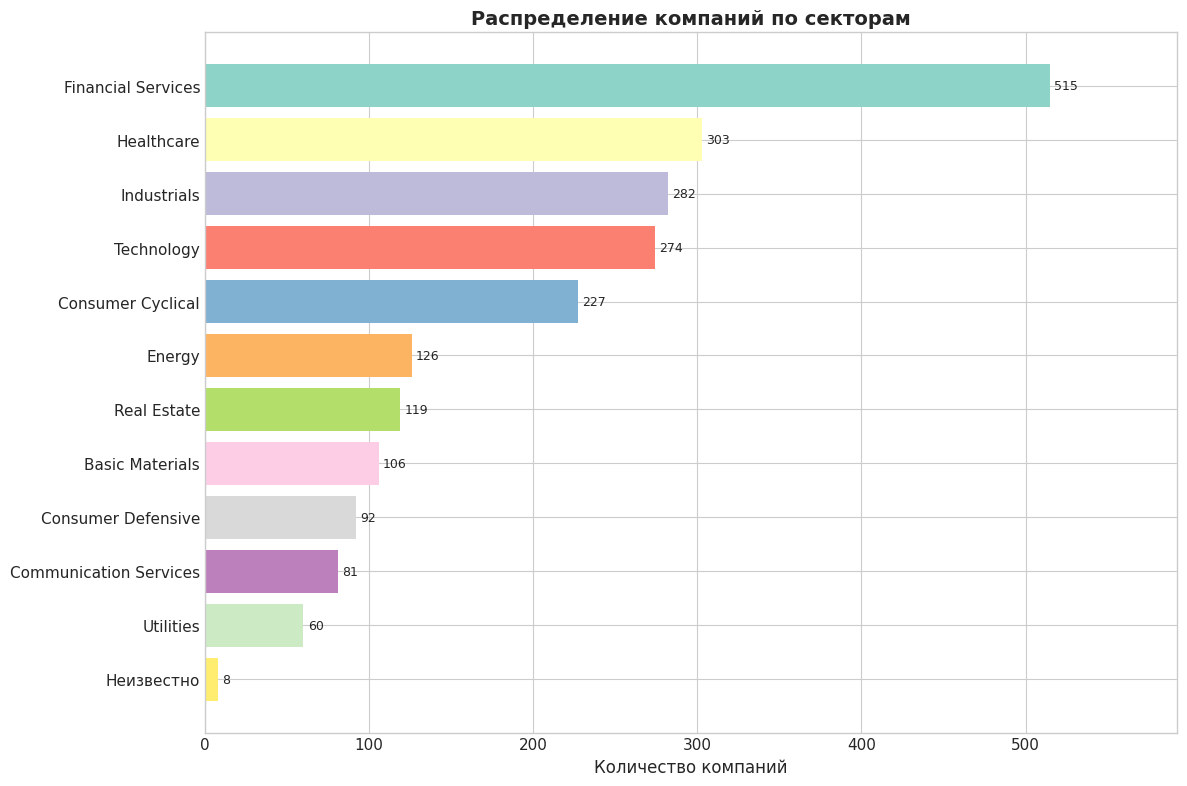

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
sector_counts = companies['sector'].fillna('Неизвестно').value_counts()
colors_sector = plt.cm.Set3(np.linspace(0, 1, len(sector_counts)))

bars = ax.barh(sector_counts.index[::-1], sector_counts.values[::-1], color=colors_sector[::-1])
ax.set_xlabel('Количество компаний')
ax.set_title('Распределение компаний по секторам', fontweight='bold')
ax.bar_label(bars, padding=3, fontsize=9)
ax.set_xlim(0, max(sector_counts.values) * 1.15)

plt.tight_layout()
plt.show()

### График 2: Распределение количества новостей по компаниям

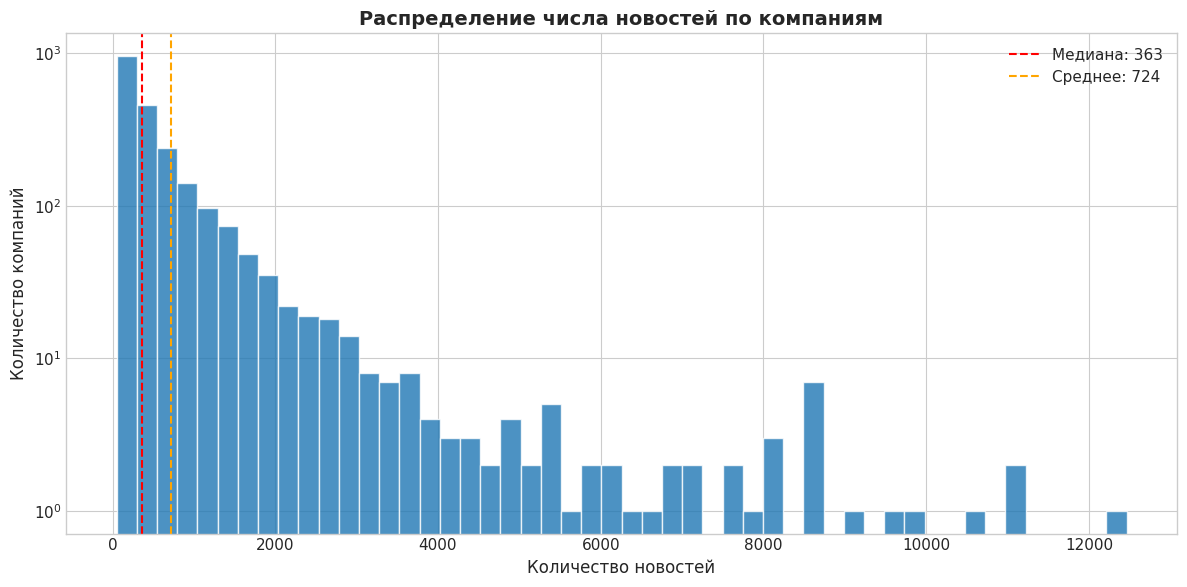

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(companies['news_count'], bins=50, edgecolor='white', alpha=0.8)

ax.axvline(companies['news_count'].median(), color='red', linestyle='--',
           label=f'Медиана: {companies["news_count"].median():.0f}')
ax.axvline(companies['news_count'].mean(), color='orange', linestyle='--',
           label=f'Среднее: {companies["news_count"].mean():.0f}')

ax.set_xlabel('Количество новостей')
ax.set_ylabel('Количество компаний')
ax.set_title('Распределение числа новостей по компаниям', fontweight='bold')
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()

### График 3: Топ-30 компаний по освещению в новостях

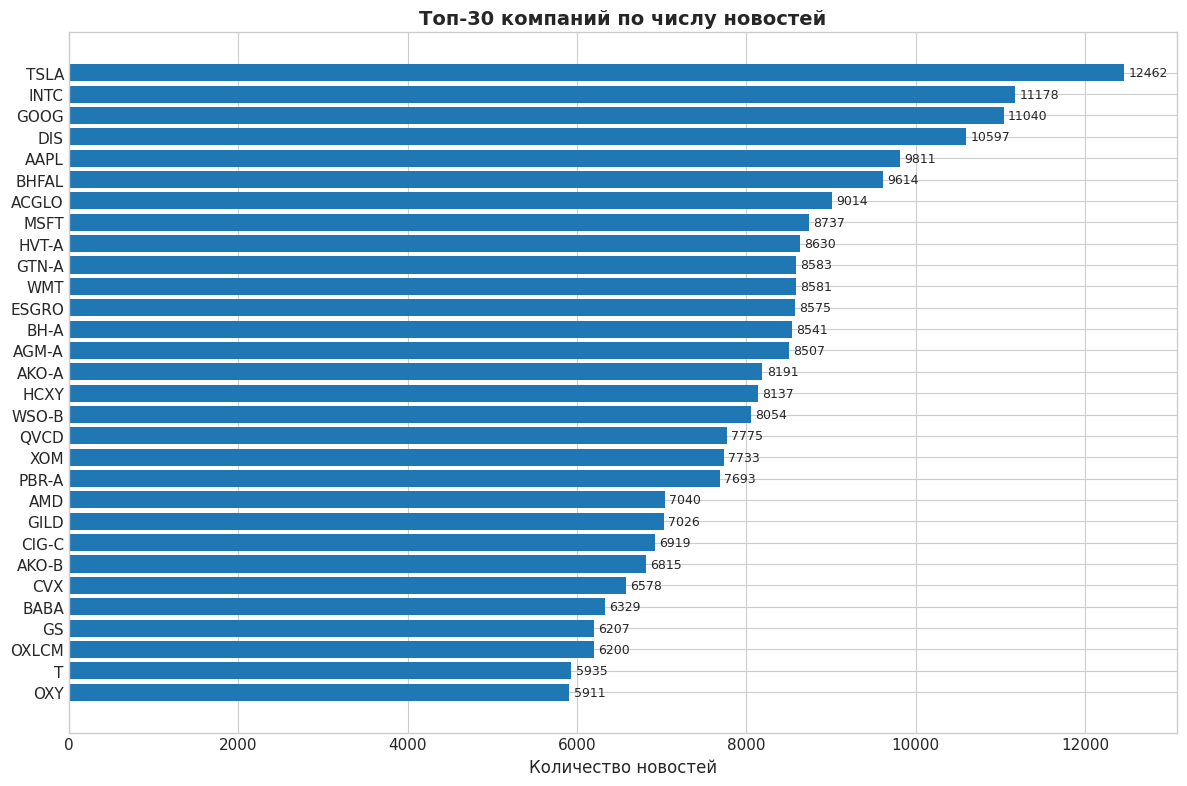

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
top30 = companies.nlargest(30, 'news_count')[['ticker', 'news_count']]
bars = ax.barh(range(len(top30)), top30['news_count'].values)

ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['ticker'].values)
ax.set_xlabel('Количество новостей')
ax.set_title('Топ-30 компаний по числу новостей', fontweight='bold')
ax.invert_yaxis()
ax.bar_label(bars, padding=3, fontsize=9)

plt.tight_layout()
plt.show()

### График 4: Распространение новостей по секторам (Топ-10)

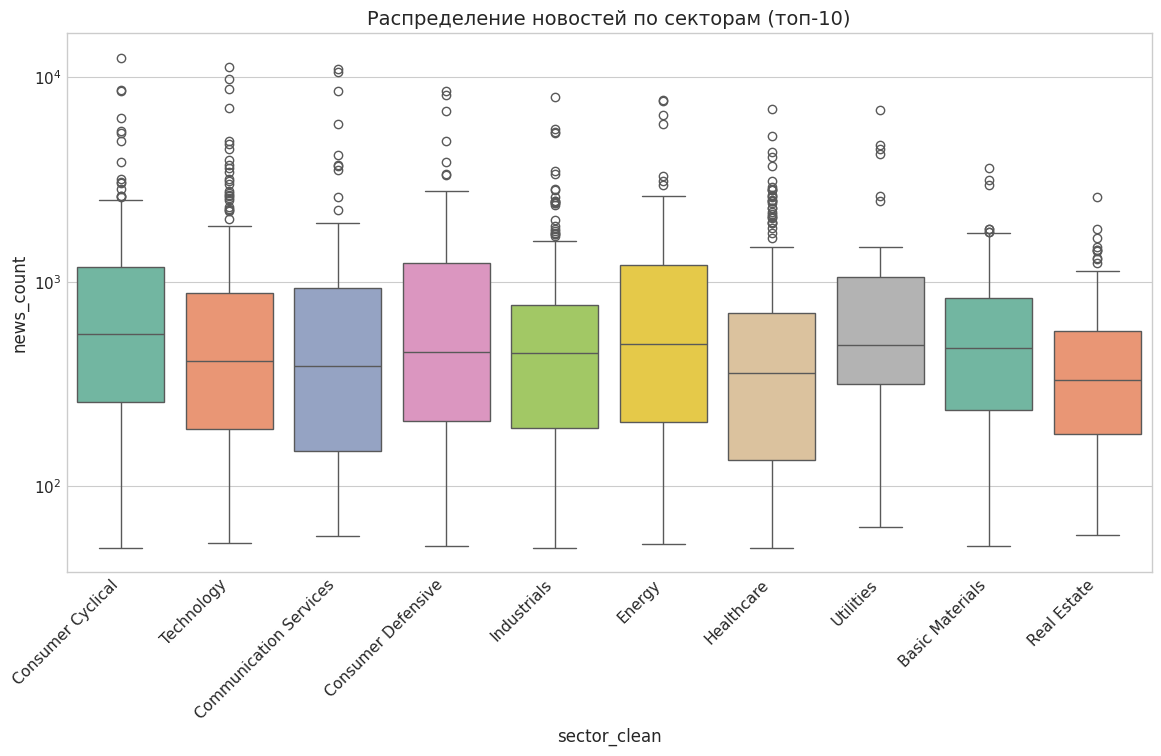

In [13]:
fig, ax = plt.subplots(figsize=(14, 7))

companies_plot = companies.copy()
companies_plot["sector_clean"] = companies_plot["sector"].fillna("Неизвестно")

tmp = companies_plot[companies_plot["sector_clean"] != "Неизвестно"]
sector_order = tmp.groupby("sector_clean")["news_count"].median().sort_values(ascending=False).index

top10 = sector_order[:10]
companies_plot = companies_plot[companies_plot["sector_clean"].isin(top10)]

sns.boxplot(data=companies_plot, x="sector_clean", y="news_count", palette="Set2")
plt.xticks(rotation=45, ha="right")
plt.yscale("log")
plt.title("Распределение новостей по секторам (топ-10)")
plt.show()

### График 5: Cоотношение ценового охвата и объема новостей

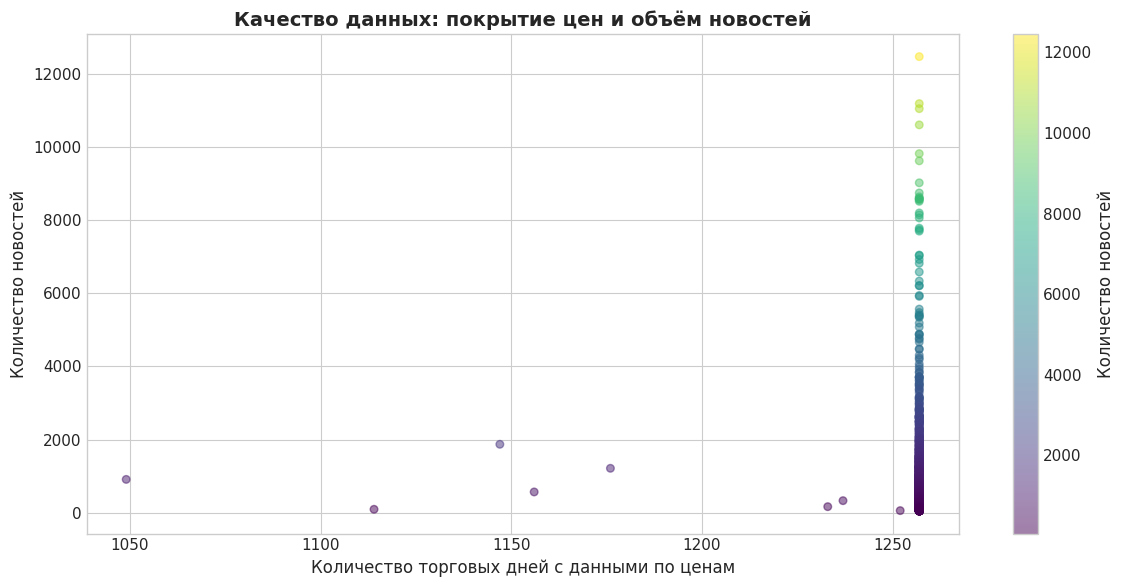

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter(companies['price_rows'], companies['news_count'],
                alpha=0.5, c=companies['news_count'], cmap='viridis', s=30)

ax.set_xlabel('Количество торговых дней с данными по ценам')
ax.set_ylabel('Количество новостей')
ax.set_title('Качество данных: покрытие цен и объём новостей', fontweight='bold')
plt.colorbar(sc, ax=ax, label='Количество новостей')

plt.tight_layout()
plt.show()

### График 6: Ликвидность и долгосрочная ценовая вариабельность акций

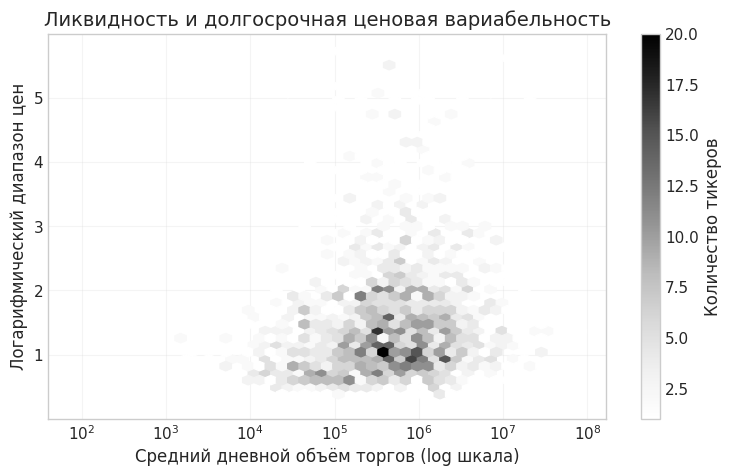

In [15]:
dfp = summary_df.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["min_price", "max_price", "avg_volume_per_day"]
)
dfp = dfp[(dfp["min_price"] > 0) & (dfp["max_price"] > 0)]
dfp["log_price_range"] = np.log(dfp["max_price"]) - np.log(dfp["min_price"])

y_max = dfp["log_price_range"].quantile(0.99)
dfp_plot = dfp[dfp["log_price_range"] <= y_max]

plt.figure(figsize=(9, 5))
plt.hexbin(
    dfp_plot["avg_volume_per_day"],
    dfp_plot["log_price_range"],
    xscale="log",
    gridsize=45,
    mincnt=1
)
plt.xlabel("Средний дневной объём торгов (log шкала)")
plt.ylabel("Логарифмический диапазон цен")
plt.title("Ликвидность и долгосрочная ценовая вариабельность")
plt.colorbar(label="Количество тикеров")
plt.grid(True, alpha=0.2)
plt.show()

### График 7: Распределение средней дневной ликвидности

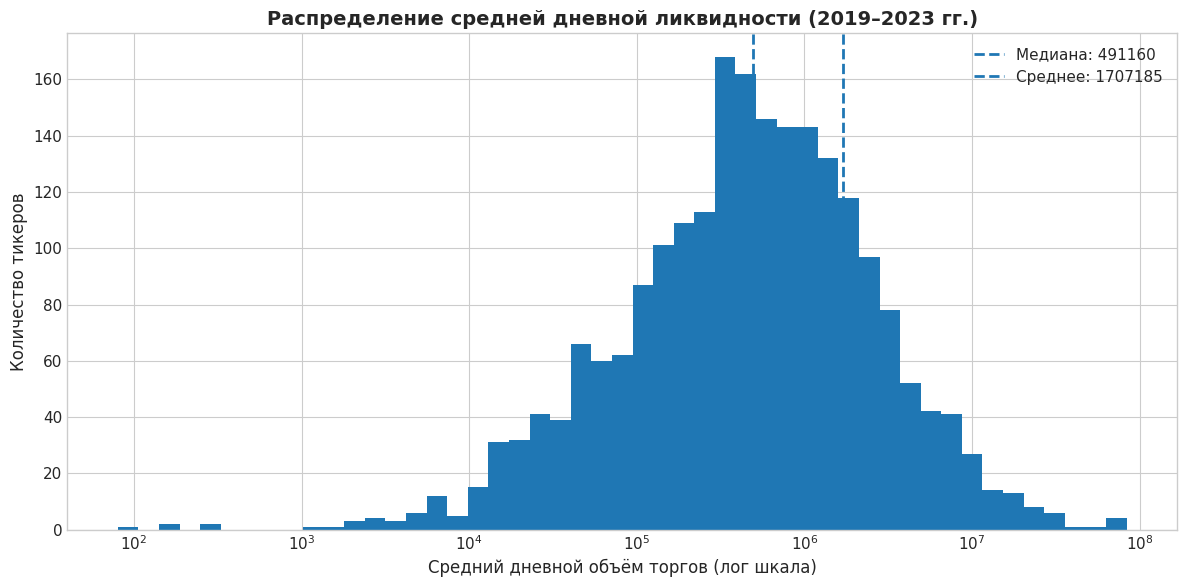

In [16]:
vol = summary_df["avg_volume_per_day"].dropna()
vol = vol[vol > 0]

bins = np.logspace(np.log10(vol.min()), np.log10(vol.max()), 50)

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(vol, bins=bins)

ax.set_xscale("log")
ax.set_xlabel("Средний дневной объём торгов (лог шкала)")
ax.set_ylabel("Количество тикеров")
ax.set_title("Распределение средней дневной ликвидности (2019–2023 гг.)", fontweight="bold")

ax.axvline(np.median(vol), linestyle="--", linewidth=2, label=f"Медиана: {np.median(vol):.0f}")
ax.axvline(np.mean(vol), linestyle="--", linewidth=2, label=f"Среднее: {np.mean(vol):.0f}")
ax.legend()

plt.tight_layout()
plt.show()

### График 8: Топ-20 наиболее активных тикеров по среднему дневному объему

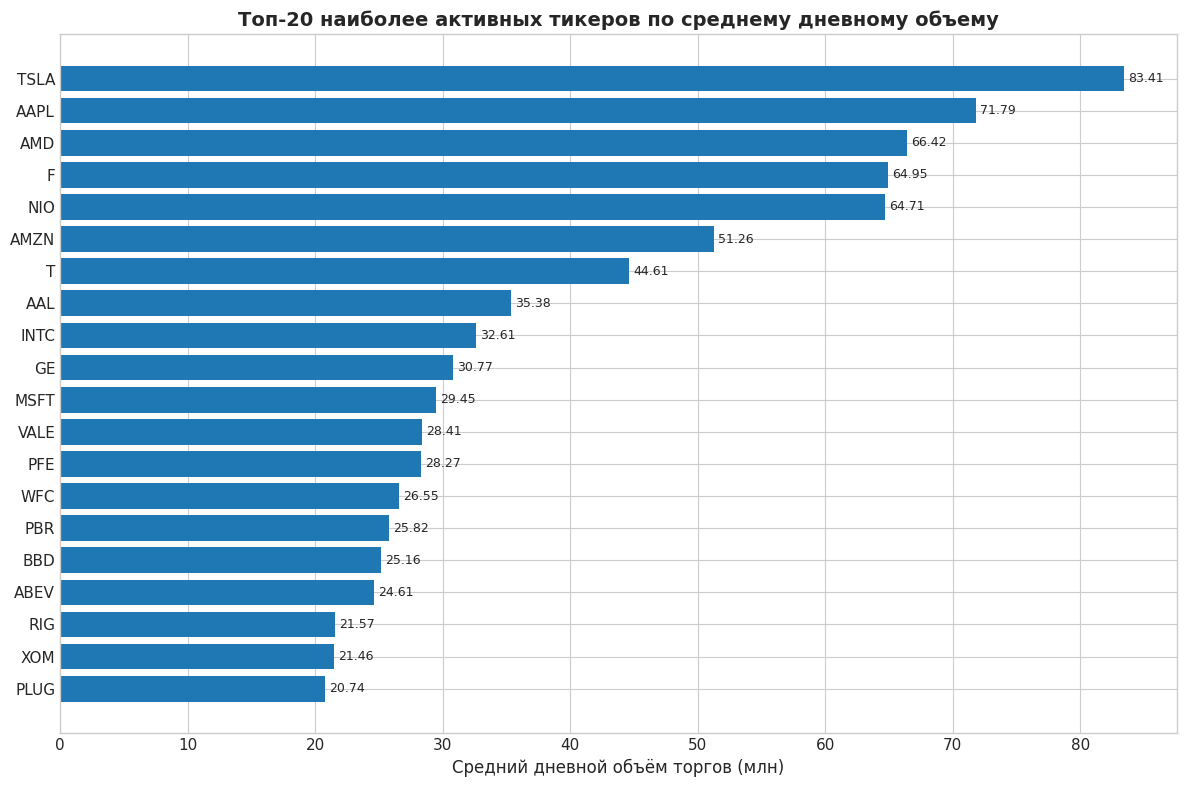

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

top20_vol = (
    summary_df.sort_values("avg_volume_per_day", ascending=False)
    .head(20)[["ticker", "avg_volume_per_day"]]
    .copy()
)

values_mln = top20_vol["avg_volume_per_day"].values / 1_000_000
bars = ax.barh(range(len(top20_vol)), values_mln)

ax.set_yticks(range(len(top20_vol)))
ax.set_yticklabels(top20_vol["ticker"].values)
ax.set_xlabel("Средний дневной объём торгов (млн)")
ax.set_title("Топ-20 наиболее активных тикеров по среднему дневному объему", fontweight="bold")
ax.invert_yaxis()
ax.bar_label(bars, padding=3, fontsize=9, fmt="%.2f")

plt.tight_layout()
plt.show()

### График 9: Концентрация новостей среди компаний (кривая Парето)

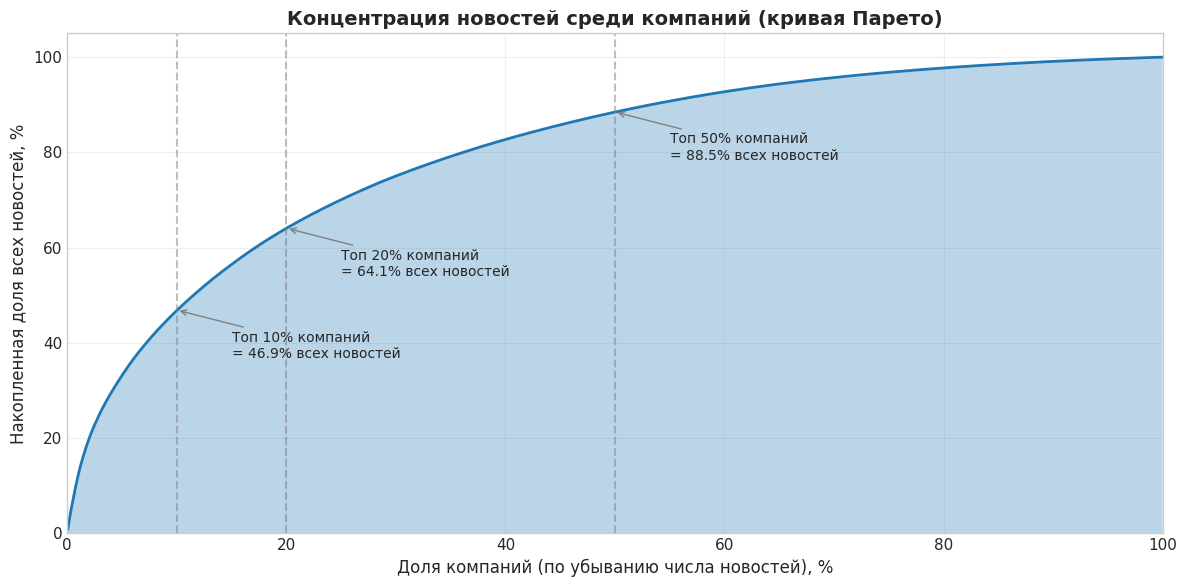

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
sorted_news = np.sort(companies['news_count'].values)[::-1]
cumsum = np.cumsum(sorted_news)
cumsum_pct = cumsum / cumsum[-1] * 100
companies_pct = np.arange(1, len(sorted_news) + 1) / len(sorted_news) * 100

ax.plot(companies_pct, cumsum_pct, linewidth=2)
ax.fill_between(companies_pct, cumsum_pct, alpha=0.3)

for pct in [10, 20, 50]:
    idx = int(len(sorted_news) * pct / 100)
    ax.axvline(pct, color='gray', linestyle='--', alpha=0.5)
    ax.annotate(f'Топ {pct}% компаний\n= {cumsum_pct[idx]:.1f}% всех новостей',
                xy=(pct, cumsum_pct[idx]),
                xytext=(pct+5, max(5, cumsum_pct[idx]-10)),
                fontsize=10,
                arrowprops=dict(arrowstyle='->', color='gray'))

ax.set_xlabel('Доля компаний (по убыванию числа новостей), %')
ax.set_ylabel('Накопленная доля всех новостей, %')
ax.set_title('Концентрация новостей среди компаний (кривая Парето)', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### График 10: Сводная статистика выборки

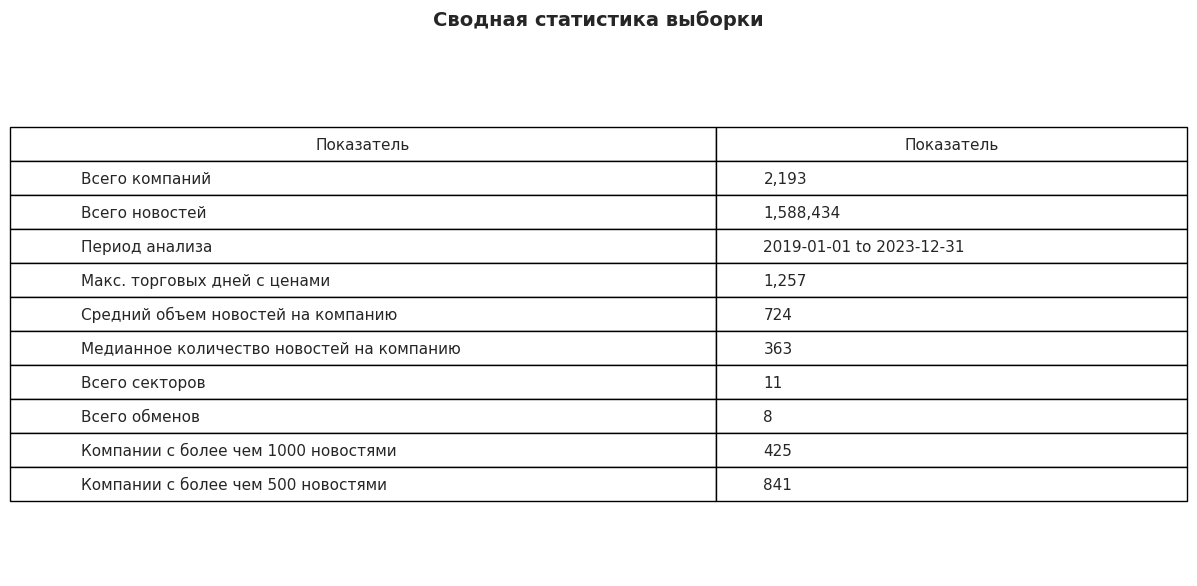

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

summary_data = [
    ['Всего компаний', f'{len(companies):,}'],
    ['Всего новостей', f'{companies["news_count"].sum():,}'],
    ['Период анализа', '2019-01-01 to 2023-12-31'],
    ['Макс. торговых дней с ценами', f'{companies["price_rows"].max():,}'],
    ['Средний объем новостей на компанию', f'{companies["news_count"].mean():,.0f}'],
    ['Медианное количество новостей на компанию', f'{companies["news_count"].median():,.0f}'],
    ['Всего секторов', f'{companies["sector"].nunique()}'],
    ['Всего обменов', f'{companies["exchange"].nunique()}'],
    ['Компании с более чем 1000 новостями', f'{(companies["news_count"] > 1000).sum():,}'],
    ['Компании с более чем 500 новостями', f'{(companies["news_count"] > 500).sum():,}']
]

table = ax.table(cellText=summary_data,
                 colLabels=['Показатель', 'Показатель'],
                 cellLoc='left', loc='center',
                 colWidths=[0.6, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax.set_title('Сводная статистика выборки', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()